Simple spam-filter classifier

## IMPORTS

#### Standards

In [1]:
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

#### Externals

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import metrics, model_selection, pipeline, preprocessing, feature_extraction, linear_model
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

## CONFIGS

In [3]:
# Paths
ROOT = Path("../")
DATA_PATH = ROOT / "data" / "SMSSpamCollection"
MODEL_DIR = ROOT / "models"

# Randomness
RANDOM_STATE = 42

# Options
pd.options.display.max_rows = None
pd.options.display.max_columns = None
sk.set_config(transform_output='pandas')



# Dataset
TEST_SIZE = 0.2
TEXT_COLUMN = "message"
TARGET_COLUMN = "label"
COLUMN_NAMES = [TARGET_COLUMN, TEXT_COLUMN]
SEPARATOR = '\t'
CV_FOLDS = 5
SHUFFLE = True

# Pipeline
NGRAM_RANGE = (1, 2)
MAX_ITER = 1000
SCORING = "f1"

## DATASETS

In [4]:
spam = pd.read_csv(DATA_PATH, 
                     delimiter=SEPARATOR,
                     header = None, 
                     names = COLUMN_NAMES)
print("Dataset shape: ",spam.shape)
spam.head()

Dataset shape:  (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
spam.info()

<class 'pandas.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   label    5572 non-null   str  
 1   message  5572 non-null   str  
dtypes: str(2)
memory usage: 87.2 KB


## ANALYSIS

In [6]:
class_counts = spam[TARGET_COLUMN].value_counts()
class_ratio = spam[TARGET_COLUMN].value_counts(normalize=True)

print(class_counts)
print(class_ratio)

label
ham     4825
spam     747
Name: count, dtype: int64
label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64


In [7]:
spam.duplicated().sum()

np.int64(403)

In [8]:
spam["message"].duplicated().sum()

np.int64(403)

## CLEANING

In [9]:
spam['label'] = spam['label'].map({'ham': 0, 'spam': 1})
spam.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
print("Size with duplicates: ", len(spam))
spam = spam.drop_duplicates()
print("Size without duplicates: ", len(spam))

Size with duplicates:  5572
Size without duplicates:  5169


## SPLITS

In [11]:
X = spam[TEXT_COLUMN]
y = spam[TARGET_COLUMN]
print("Inputs shape: ", X.shape, "Targets shape: " , y.shape)

Inputs shape:  (5169,) Targets shape:  (5169,)


In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                    y, 
                                                                    test_size=TEST_SIZE, 
                                                                    random_state=RANDOM_STATE,
                                                                    shuffle=SHUFFLE,
                                                                    stratify=y)

## MODELS

In [13]:
base_model =  pipeline.Pipeline([('vectorizer', feature_extraction.text.TfidfVectorizer(stop_words = 'english')),
                               ('model',  linear_model.LogisticRegression(max_iter= MAX_ITER))])

In [14]:
base_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vectorizer', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


## EVALUATIONS

In [15]:
predictions = base_model.predict(X_test)

In [16]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       903
           1       0.98      0.67      0.80       131

    accuracy                           0.96      1034
   macro avg       0.97      0.83      0.89      1034
weighted avg       0.96      0.96      0.95      1034



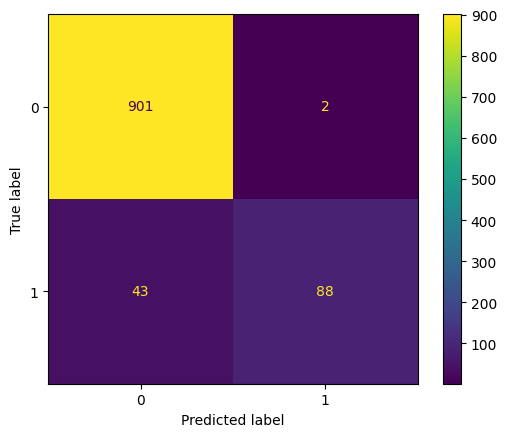

In [17]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)